In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opendatasets --upgrade --quiet

In [4]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nguyenhungtien
Your Kaggle Key: ··········


100%|██████████| 395M/395M [00:10<00:00, 38.5MB/s]


In [5]:
import os 

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [6]:
print(os.listdir(DATA_DIR+'/images')[:10])

['58359_2017.jpg', '2797_2002.jpg', '40601_2013.jpg', '60843_2018.jpg', '53946_2016.jpg', '48057_2014.jpg', '56259_2017.jpg', '43729_2013.jpg', '14133_2006.jpg', '56120_2017.jpg']


In [7]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [8]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [9]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
train_dl

In [12]:
for xb, yb in train_dl:
  print(xb.shape)
  print(yb.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 3, 64, 64])
torch.Size([128])


Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.


In [13]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [15]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [18]:
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


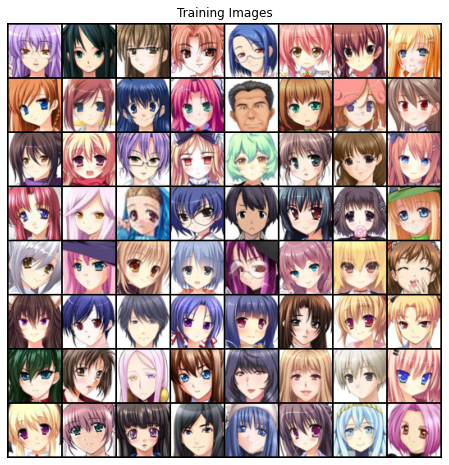

In [22]:
import numpy as np
import torchvision.utils as vutils

# Plot some training images
real_batch = next(iter(train_dl))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

##Using The GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and a helper class **DeviceDataLoader** to move our model & data to the GPU, if one is available.

In [23]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [24]:
device = get_default_device()
device

device(type='cuda')

In [25]:
train_dl = DeviceDataLoader(train_dl, device)

##Discriminator Network

In [26]:
import torch.nn as nn

In [27]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [28]:
discriminator = to_device(discriminator, device) 

##Generator Network

In [29]:
latent_size = 128

In [30]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


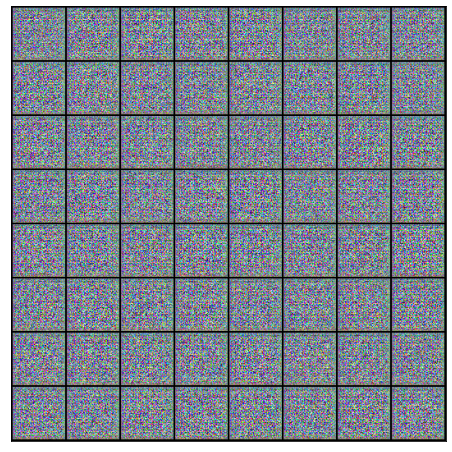

In [31]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [32]:
generator = to_device(generator, device)

##Discriminator Training

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

In [33]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

##Generator Training

In [34]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [35]:
from torchvision.utils import save_image

In [36]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [37]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [38]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


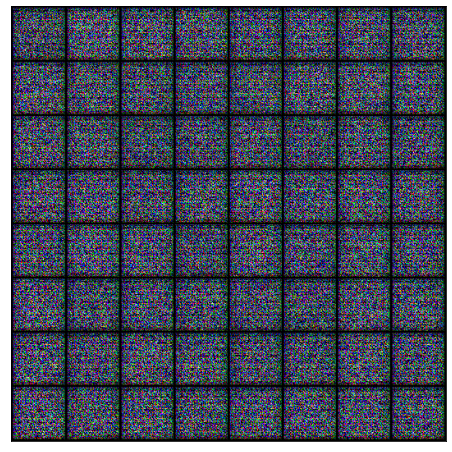

In [39]:
save_samples(0, fixed_latent)

##Full Training Loop

In [40]:
from tqdm import tqdm 
import torch.nn.functional as F

In [41]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [42]:
lr = 0.0002
epochs = 25

In [43]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 497/497 [05:18<00:00,  1.56it/s]


Epoch [1/25], loss_g: 4.0758, loss_d: 0.5790, real_score: 0.6505, fake_score: 0.0460
Saving generated-images-0001.png


100%|██████████| 497/497 [05:18<00:00,  1.56it/s]


Epoch [2/25], loss_g: 7.2021, loss_d: 1.3606, real_score: 0.3624, fake_score: 0.0014
Saving generated-images-0002.png


100%|██████████| 497/497 [05:18<00:00,  1.56it/s]


Epoch [3/25], loss_g: 4.3872, loss_d: 2.0836, real_score: 0.2254, fake_score: 0.0007
Saving generated-images-0003.png


100%|██████████| 497/497 [05:19<00:00,  1.56it/s]


Epoch [4/25], loss_g: 4.0972, loss_d: 0.3512, real_score: 0.7635, fake_score: 0.0215
Saving generated-images-0004.png


100%|██████████| 497/497 [05:18<00:00,  1.56it/s]


Epoch [5/25], loss_g: 5.2536, loss_d: 0.2047, real_score: 0.8909, fake_score: 0.0582
Saving generated-images-0005.png


100%|██████████| 497/497 [05:18<00:00,  1.56it/s]


Epoch [6/25], loss_g: 5.3046, loss_d: 0.1506, real_score: 0.9122, fake_score: 0.0335
Saving generated-images-0006.png


100%|██████████| 497/497 [05:18<00:00,  1.56it/s]


Epoch [7/25], loss_g: 4.0127, loss_d: 0.1174, real_score: 0.9202, fake_score: 0.0176
Saving generated-images-0007.png


100%|██████████| 497/497 [05:18<00:00,  1.56it/s]


Epoch [8/25], loss_g: 3.1781, loss_d: 0.2786, real_score: 0.8092, fake_score: 0.0336
Saving generated-images-0008.png


100%|██████████| 497/497 [05:18<00:00,  1.56it/s]


Epoch [9/25], loss_g: 4.1028, loss_d: 0.1493, real_score: 0.9336, fake_score: 0.0694
Saving generated-images-0009.png


100%|██████████| 497/497 [05:18<00:00,  1.56it/s]


Epoch [10/25], loss_g: 4.6494, loss_d: 0.1147, real_score: 0.9479, fake_score: 0.0500
Saving generated-images-0010.png


100%|██████████| 497/497 [05:18<00:00,  1.56it/s]


Epoch [11/25], loss_g: 5.3838, loss_d: 0.1061, real_score: 0.9749, fake_score: 0.0714
Saving generated-images-0011.png


100%|██████████| 497/497 [05:18<00:00,  1.56it/s]


Epoch [12/25], loss_g: 7.6943, loss_d: 0.1921, real_score: 0.9597, fake_score: 0.1193
Saving generated-images-0012.png


100%|██████████| 497/497 [05:18<00:00,  1.56it/s]


Epoch [13/25], loss_g: 5.0896, loss_d: 0.2487, real_score: 0.8183, fake_score: 0.0075
Saving generated-images-0013.png


100%|██████████| 497/497 [05:18<00:00,  1.56it/s]


Epoch [14/25], loss_g: 9.1402, loss_d: 0.5122, real_score: 0.9828, fake_score: 0.3163
Saving generated-images-0014.png


100%|██████████| 497/497 [05:18<00:00,  1.56it/s]


Epoch [15/25], loss_g: 5.4360, loss_d: 0.0745, real_score: 0.9743, fake_score: 0.0436
Saving generated-images-0015.png


100%|██████████| 497/497 [05:18<00:00,  1.56it/s]


Epoch [16/25], loss_g: 3.3344, loss_d: 0.4176, real_score: 0.7557, fake_score: 0.0347
Saving generated-images-0016.png


100%|██████████| 497/497 [05:20<00:00,  1.55it/s]


Epoch [17/25], loss_g: 3.2810, loss_d: 0.2885, real_score: 0.8048, fake_score: 0.0182
Saving generated-images-0017.png


100%|██████████| 497/497 [05:18<00:00,  1.56it/s]


Epoch [18/25], loss_g: 5.5811, loss_d: 0.1626, real_score: 0.9250, fake_score: 0.0674
Saving generated-images-0018.png


100%|██████████| 497/497 [05:18<00:00,  1.56it/s]


Epoch [19/25], loss_g: 9.8173, loss_d: 0.4813, real_score: 0.9945, fake_score: 0.3254
Saving generated-images-0019.png


100%|██████████| 497/497 [05:18<00:00,  1.56it/s]


Epoch [20/25], loss_g: 4.6389, loss_d: 0.1007, real_score: 0.9598, fake_score: 0.0540
Saving generated-images-0020.png


100%|██████████| 497/497 [05:18<00:00,  1.56it/s]


Epoch [21/25], loss_g: 1.3820, loss_d: 0.3278, real_score: 0.7726, fake_score: 0.0139
Saving generated-images-0021.png


100%|██████████| 497/497 [05:18<00:00,  1.56it/s]


Epoch [22/25], loss_g: 4.9515, loss_d: 0.1475, real_score: 0.8963, fake_score: 0.0163
Saving generated-images-0022.png


100%|██████████| 497/497 [05:19<00:00,  1.56it/s]


Epoch [23/25], loss_g: 6.5810, loss_d: 0.3503, real_score: 0.9462, fake_score: 0.2162
Saving generated-images-0023.png


100%|██████████| 497/497 [05:17<00:00,  1.56it/s]


Epoch [24/25], loss_g: 4.3674, loss_d: 0.2049, real_score: 0.9481, fake_score: 0.1157
Saving generated-images-0024.png


100%|██████████| 497/497 [05:17<00:00,  1.56it/s]

Epoch [25/25], loss_g: 4.1467, loss_d: 0.1849, real_score: 0.9367, fake_score: 0.0970
Saving generated-images-0025.png


In [44]:
losses_g, losses_d, real_scores, fake_scores = history

In [45]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [46]:
from IPython.display import Image

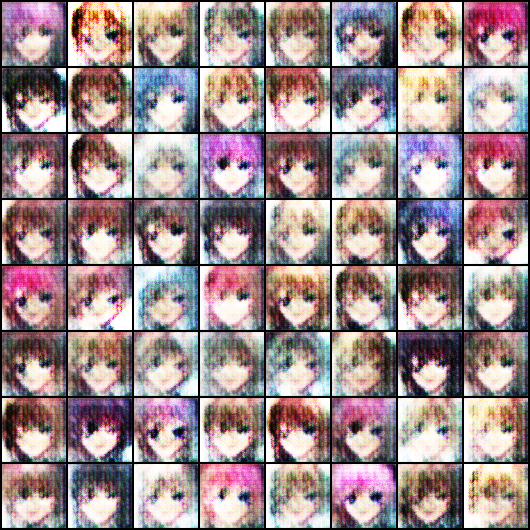

In [47]:
Image('./generated/generated-images-0001.png')

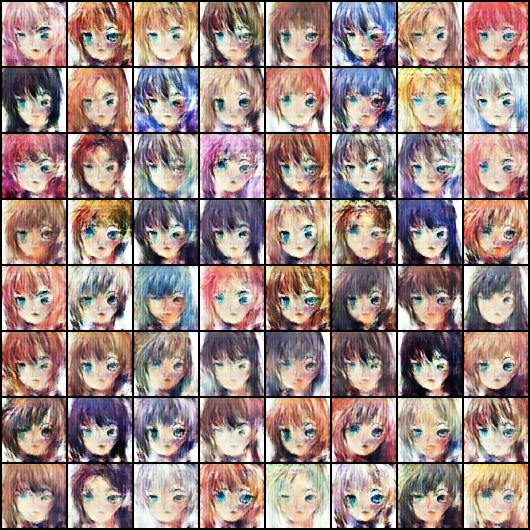

In [48]:
Image('./generated/generated-images-0005.png')

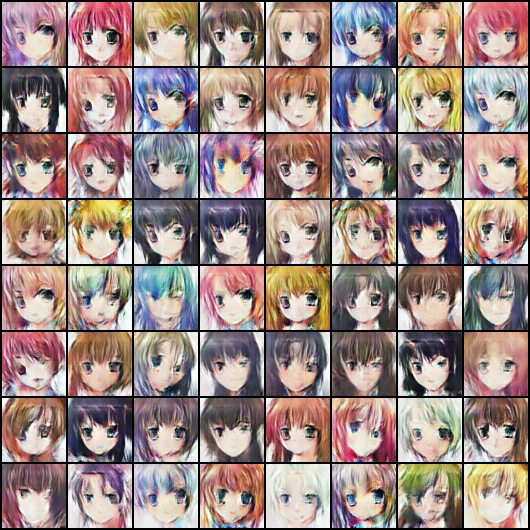

In [49]:
Image('./generated/generated-images-0010.png')

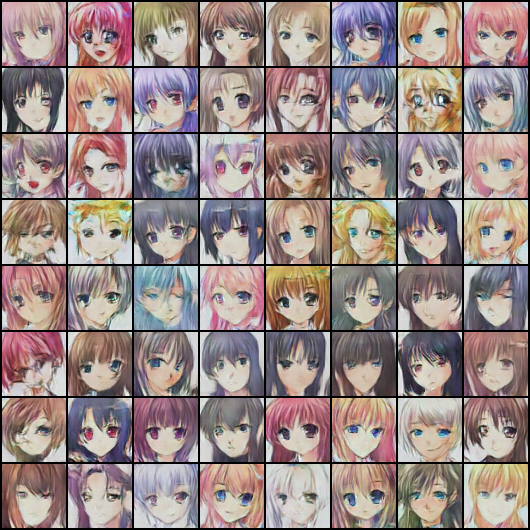

In [50]:
Image('./generated/generated-images-0020.png')

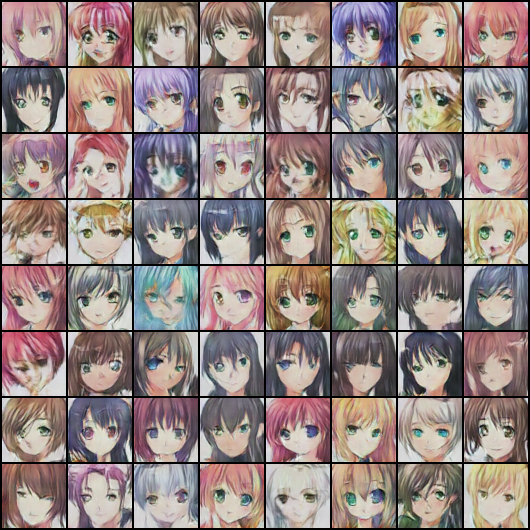

In [51]:
Image('./generated/generated-images-0025.png')

In [52]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

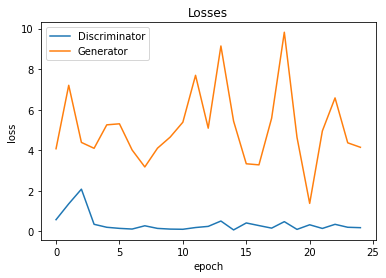

In [53]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

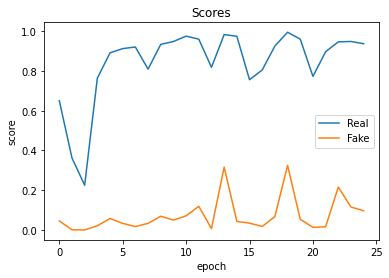

In [54]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');